# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- Work on some features.
- Check classification instead of regression as well - will the stock go up or down?
- Maybe try predicting only 6 months in advance instead of a year.
- Need to do a large parameter search for XGBoost.

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [15]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
#tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")
tickers = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
tickers.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,PIH,"1347 Property Insurance Holdings, Inc.",6.5001,3.873322e+07,n/a,2014,Finance,Property-Casualty Insurers,http://www.nasdaq.com/symbol/pih,NaN
1,FCCY,1st Constitution Bancorp (NJ),18,1.436993e+08,n/a,n/a,Finance,Savings Institutions,http://www.nasdaq.com/symbol/fccy,NaN
2,SRCE,1st Source Corporation,44.82,1.159751e+09,n/a,n/a,Finance,Major Banks,http://www.nasdaq.com/symbol/srce,NaN
3,ABIL,Ability Inc.,3.21,8.267722e+07,n/a,2014,Finance,Business Services,http://www.nasdaq.com/symbol/abil,NaN
4,ABM,ABM Industries Incorporated,40.86,2.270007e+09,n/a,n/a,Finance,Diversified Commercial Services,http://www.nasdaq.com/symbol/abm,NaN


## Get Data

In [16]:
#scrapes financial data from Morningstar, gets features
def get_stock_financials(stock,year):
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') # save as test.gif
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):
            #print 'skipping %s, stock in EUR/AUD'%stock
            return pd.DataFrame(columns=d.columns)  #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    d.insert(0,'stock',stock)
    for dc in del_columns: #delete annoying repeated columns
        try:
            del d[dc]
        except:
            pass
    return d[d['index'].str.contains("%d"%year)]

#small helper function for getting target
def last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BM')

#scrapes data from yahoo, gets target
def get_frac_price_change(stock,date):
    last_current = last_weekday_of_month(date)
    ds = date.split('-')
    last_future = last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    current_price = DataReader(stock, 'yahoo', last_current, last_current)['Adj Close'].values[0]
    future_price = DataReader(stock, 'yahoo', last_future, last_future)['Adj Close'].values[0]
    return (future_price - current_price)/current_price
    
#simple progress bar
def log_progress(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item
    
#Top-level function which acquires all the data
def get_data(stocks,year):
    #create empty dataframe with available columns
    cols = get_stock_financials(stocks["Symbol"][0],year).columns
    X = pd.DataFrame(columns=cols)
    y = []
    skip = []
    #for s in stocks["Symbol"][0:100]:
    for s in log_progress(stocks["Symbol"], len(stocks["Symbol"])/10):
        try:
            _X = get_stock_financials(s,year)
            _y = get_frac_price_change(s,_X['index'].values[0])
            if _X.shape[1] > 1 and _y: #only append if alg actually recovered data
                X = X.append(_X)
                y.append(_y)
        except:
            skip.append(s)
    X = X.set_index('stock')
    #X = pd.to_numeric(X)
    X = X.convert_objects(convert_numeric=True)
    return X, y, skip

In [17]:
#stocks = pd.read_csv('csv/s&p500.csv',delimiter=",")
stocks = pd.read_csv('csv/nasdaq/Finance.csv',delimiter=",")
year = 2014

X, y, skip = get_data(stocks, year)

 0.0 0.0997008973081 0.199401794616 0.299102691924 0.398803589232 0.49850448654 0.598205383848 0.697906281157 0.797607178465 0.897308075773 0.997008973081/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:70: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [18]:
#all available columns for analysis
#X.columns

In [19]:
#X['Debt/Equity'] = pd.to_numeric(X['Debt/Equity'])
#X = X.convert_objects(convert_numeric=True)

## Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [20]:
percentiles = ['Net Margin %','Gross Margin %','Operating Margin %','Return on Assets %', 'Payout Ratio % *',
               'Return on Invested Capital %','Return on Equity %','Free Cash Flow/Sales %']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD', 'Debt/Equity',
         'Current Ratio','Dividends USD','EBT Margin','Quick Ratio']

columns = percentiles + ratios

In [50]:
XX = X[columns]

In [51]:
#replace NaN values with median of column if they represent <10% of values
for c in columns:
    frac_NaN = XX[c].isnull().sum()/float(len(XX))
    if frac_NaN > 0.1:
        del XX[c]
    else:
        XX[c] = pd.to_numeric(XX[c])
        XX[c].fillna(XX[c].median(), inplace=True)
    print "%s: NaN fraction = %.4f"%(c, frac_NaN)

columns = XX.columns

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Net Margin %: NaN fraction = 0.0182
Operating Margin %: NaN fraction = 0.0126
Return on Assets %: NaN fraction = 0.0028
Return on Equity %: NaN fraction = 0.0168
Free Cash Flow/Sales %: NaN fraction = 0.0154
Book Value Per Share * USD: NaN fraction = 0.0965
Earnings Per Share USD: NaN fraction = 0.0881
Free Cash Flow Per Share * USD: NaN fraction = 0.0993
EBT Margin: NaN fraction = 0.0140


In [23]:
XX.head()

,Net Margin %,Operating Margin %,Return on Assets %,Return on Equity %,Free Cash Flow/Sales %,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin
stock,,,,,,,,,
PIH,16.59,30.2,6.46,10.89,66.87,7.74,0.71,3.31,30.21
FCCY,11.32,13.7,0.51,5.60,40.26,10.74,0.55,2.08,13.74
SRCE,24.38,35.4,1.22,9.68,30.77,22.97,2.17,2.74,35.45
ABM,1.50,2.5,3.51,8.02,1.79,17.12,1.32,1.20,2.38
ANCX,25.54,39.4,1.47,14.66,-15.76,9.53,1.33,-1.50,39.45


In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.33, random_state=42)

## Machine Learning tyme

In [27]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV  #maybe try RandomizedSearchCV, probably better
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

### Best params so far:
-0.111054839795
{'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1}

In [28]:
model = xgb.XGBClassifier()
n_cv = 3    #use 3 since dataset is kind of small
param_grid={
    'learning_rate': [0.01],
    'max_depth': [4],
    'min_child_weight': [0.1],
    'n_estimators':[2000],
}
grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

-0.0820728808253
{'n_estimators': 2000, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 0.1}


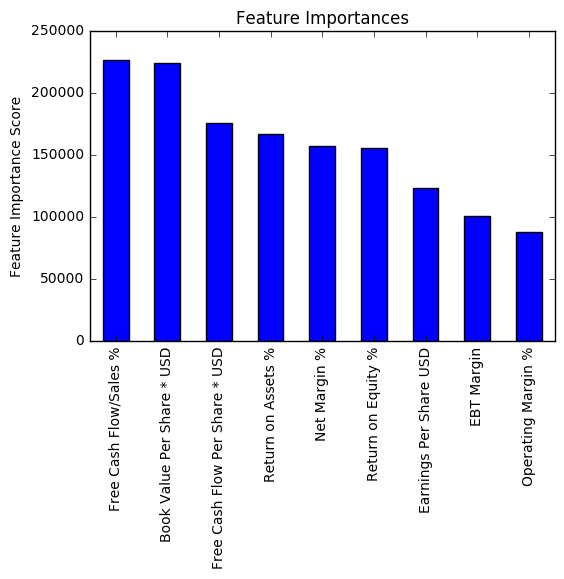

In [29]:
model = grid.best_estimator_
feat_imp = pd.Series(model.booster().get_fscore()).sort_values(ascending=False) #seems equivalent to model.feature_importances_
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [30]:
y_test_predict = model.predict(X_test)

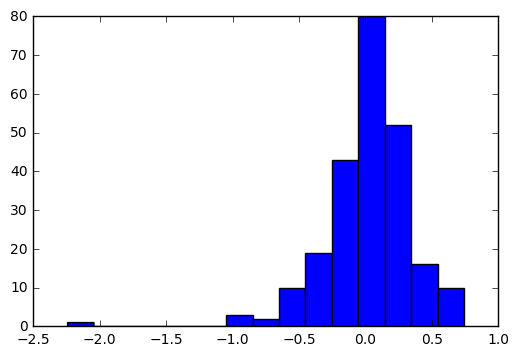

In [38]:
_,_,_ = plt.hist(y_test_predict - y_test, 15)

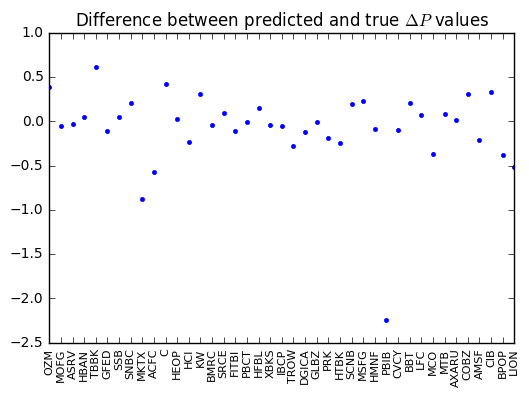

In [43]:
#plt.plot(y_test_predict, '.', label='predicted')
#plt.plot(y_test, '.', label='true')
plt.plot(y_test_predict - y_test, '.')
plt.legend(fontsize=8, numpoints=1)
plt.xticks(range(len(y_test)), X_test.index, rotation='vertical', fontsize=8)
plt.xlim([80,120])
plt.title('Difference between predicted and true $\Delta P$ values');

# Extra

In [38]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [33]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [32]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [24]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()